In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import transforms
#from torchsummary import summary
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from PIL import Image
import pydensecrf.densecrf as dcrf
from sklearn.cluster import KMeans

In [7]:
test_list = sorted([os.path.join('dataset2/test_RES/',img) for img in os.listdir('dataset2/test_RES/')])
testdata_list = sorted([os.path.join('dataset2/test/',img) for img in os.listdir('dataset2/test/')])

In [8]:
def loadpro_img(file_names):
    images = []
    for file_name in file_names:
        img = cv2.imread(file_name,-1)#读取时不做改变，默认参数1加载彩色图片
        img = img.astype(np.uint8)
        #img = Image.fromarray(img)
        images.append(img)
    return np.array(images)

In [9]:
test_data = loadpro_img(test_list)
test_img = loadpro_img(testdata_list)

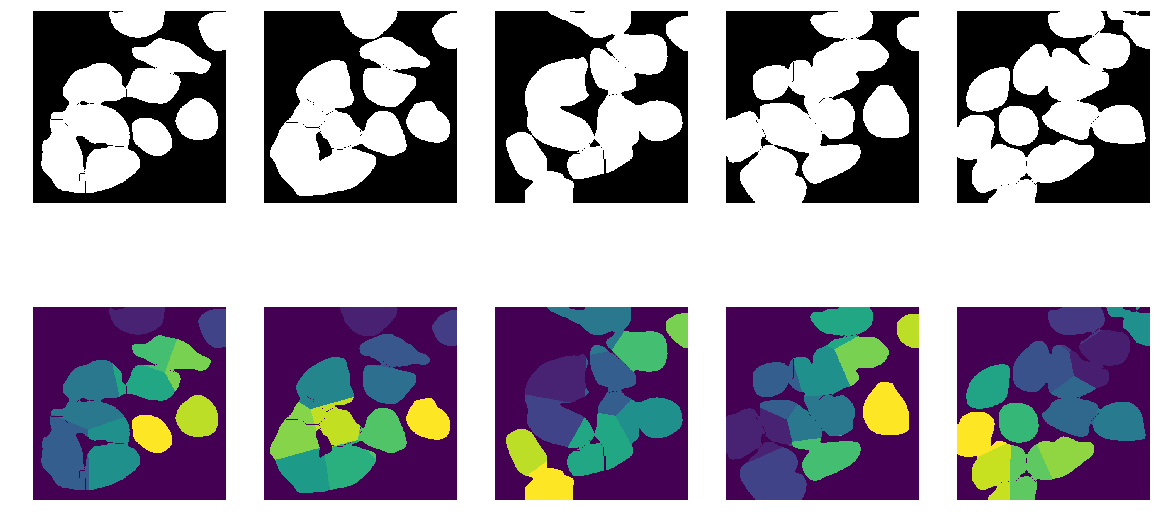

In [41]:
plt.figure(figsize=(20,10))
for i in range(5):
    img = test_data[i]
    mask = np.zeros(img.shape,np.uint8)
    mask[img>0] = 1
    res = kluster_proess(mask)
    plt.subplot(2,5,i+1)
    plt.imshow(mask,'gray')
    plt.axis('off') 
    plt.subplot(2,5,i+6)
    plt.imshow(res)
    plt.axis('off') 
plt.savefig('clusters.png')
plt.show()

1 11 11


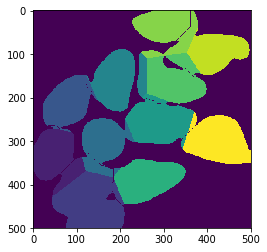

In [266]:
img = test_data[5]
mask = np.zeros(img.shape,np.uint8)
mask[img>0] = 1
res = kluster_proess(mask)

### 连通域聚类

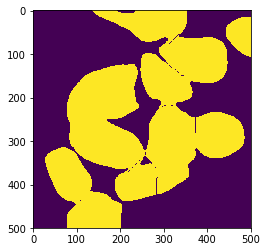

In [234]:
plt.imshow(mask)
plt.show()

In [13]:
maxval,pred_img,_,centorids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

In [40]:
def kluster_proess(mask):
    maxval,pred_img,_,_ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    zonelabels = np.unique(pred_img)
    imgpro = np.zeros(mask.shape,np.uint8)
    curnum = 0
    for i in range(1,len(zonelabels)):
        zone = np.zeros(mask.shape,np.uint8)
        zone[pred_img==i]=1
        index = np.argwhere(pred_img==i)
        # plt.imshow(zone)
        # plt.show()
        #erode
        kernel = np.ones((3,3),np.uint8)
        img_erode = cv2.erode(zone,kernel,iterations = 20)
        # plt.imshow(img_erode)
        # plt.show()

        #clusters
        maxval,curzone,_,centorids = cv2.connectedComponentsWithStats(img_erode, 4, cv2.CV_32S)
        curlabels = np.unique(curzone)
        kclasses = len(curlabels)-1

        flags = centorids[1:,:]
        if len(flags)>0:
            dataxy = index.astype(np.float32)
            clf = KMeans(n_clusters=kclasses,init=flags,n_init=1,tol=1e-6)
            clf.fit(dataxy)
            clf.labels_ += 1 #最小标签是0

            clf.labels_ += curnum #防止标签重复
            for j in range(len(index)):
                imgpro[index[j,0]][index[j,1]] = clf.labels_[j]
            curnum = np.max(clf.labels_)
            #print(i,kclasses,curnum)
        else:
            for j in range(len(index)):
                imgpro[index[j,0]][index[j,1]] = 55+curnum
            curnum = 1
            #print(i,curnum)
#     plt.imshow(imgpro)
#     plt.show()
    return imgpro

In [6]:
def watershed_process(mask):
    kernel = np.ones((3,3),np.uint8)
    # sure background area
    sure_bg = cv2.dilate(mask,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(mask,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.592*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    # Now, mark the region of unknown with zero
    markers[unknown == 1] = 0
    #predpro = 255 - predpro
    rgb = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    markers2 = cv2.watershed(rgb,markers)
    newmark=markers2
    newmark[markers2==-1] = 1
    newmark = newmark-1
    return newmark

1 1 1
2 1 2
3 2 4
4 5 9
5 1 10


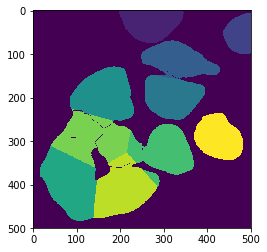

In [240]:
res = kluster_proess(mask)

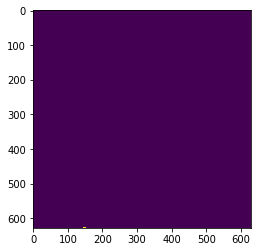

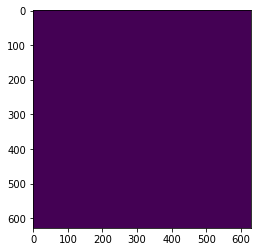

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [195]:
imgpro = np.zeros(mask.shape,np.uint8)
zone = np.zeros(mask.shape,np.uint8)
maxval,pred_img,_,_ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
zone[pred_img==27]=1
index = np.argwhere(pred_img==22)
plt.imshow(zone)
plt.show()
#erode
kernel = np.ones((3,3),np.uint8)
img_erode = cv2.erode(zone,kernel,iterations = 10)
plt.imshow(img_erode)
plt.show()
maxval,curzone,_,centorids = cv2.connectedComponentsWithStats(img_erode, 4, cv2.CV_32S)
curlabels = np.unique(curzone)
kclasses = len(curlabels)-1
dataxy = index.astype(np.float32)
flags = centorids[1:,:]
if len(flags)>0:
        dataxy = index.astype(np.float32)
        clf = KMeans(n_clusters=kclasses,init=flags,n_init=1,tol=1e-6)
        clf.fit(dataxy)
        clf.labels_ += 1 #最小标签是0
        clf.labels_ += curnum #防止标签重复
        for j in range(len(index)):
            imgpro[index[j,0]][index[j,1]] = clf.labels_[j]
        curnum = np.max(clf.labels_)
        print(i,kclasses,curnum)
else:
        for j in range(len(index)):
            imgpro[index[j,0]][index[j,1]] = curnum + 1
        curnum = 1

In [200]:
np.unique(pred_img)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int32)

In [158]:
kclasses

2

In [148]:
centorids

array([[313.5253017 , 313.15204918],
       [323.48713235, 434.68198529],
       [281.90759754, 459.17659138]])

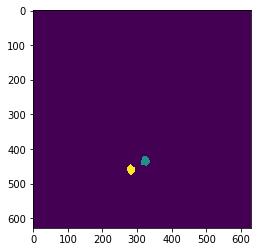

In [147]:
plt.imshow(curzone)
plt.show()

E:\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:968: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


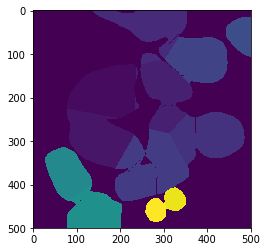

In [150]:
zone = np.zeros(mask.shape,np.uint8)
maxval,pred_img,_,_ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
zone[pred_img==14]=1
index = np.argwhere(pred_img==14)
# plt.imshow(zone)
# plt.show()
#erode
kernel = np.ones((3,3),np.uint8)
img_erode = cv2.erode(zone,kernel,iterations = 10)
#clusters
maxval,curzone,_,centorids = cv2.connectedComponentsWithStats(img_erode, 4, cv2.CV_32S)
curlabels = np.unique(curzone)
kclasses = len(curlabels)-1
dataxy = index.astype(np.float32)
flags = centorids[1:,:]
clf = KMeans(n_clusters=kclasses,init=flags,tol=1e-6)
clf.fit(dataxy)
clf.labels_ += 1 #最小标签是0

clf.labels_ += curnum #防止标签重复
for j in range(len(index)):
    imgpro[index[j,0]][index[j,1]] = clf.labels_[j]
plt.imshow(imgpro)
plt.show()

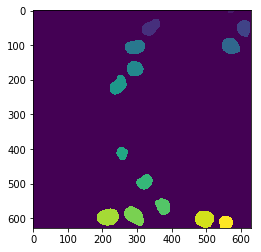

In [81]:
plt.imshow(pred_img)
plt.show()

In [165]:
np.unique(res)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=uint8)

In [ ]:
import imageio
result_path = 'dataset2/test_RES'
test_list = sorted([os.path.join('dataset2/test/',img) for img in os.listdir('dataset2/test/')])
test_data = loadpro_img(test_list)

In [78]:
len(flags)

0

In [56]:
np.max(clf.labels_)

7

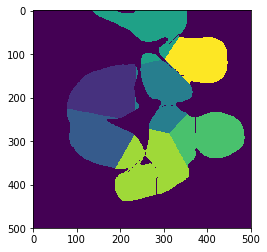

In [55]:
clf.labels_ += 1
imgpro = np.zeros(img.shape,np.uint8)
for i in range(len(index)):
    imgpro[index[i,0]][index[i,1]] = clf.labels_[i]
plt.imshow(imgpro)
plt.show()

In [16]:
labels = np.unique(pred_img)
for i in range(1,len(labels)):
    zone = np.zeros(img.shape,np.uint8)
    zone[pred_img==labels[i]]=1
    

array([0, 1, 2, 3], dtype=int32)

In [ ]:
def get_onelabelmap(data,label):
    index = np.argwhere(data==label)
    sam = np.zeros(data.shape)
    for i in range(len(index)):
        sam[index[i][0]][index[i][1]] = 1
    sam = sam.astype(np.int32)#注意类型转换，否则无法进行与运算
    return sam
def get_fit_GTimgs(cell_pred,label,cell_gt):
    #对于每个预测标签细胞，求与其匹配的gt细胞
    fit_lists = []
    Jaccard_lists = []
    labels = np.unique(cell_pred)
    cell_gt_map = get_onelabelmap(cell_gt,label)
    for i in range(1,len(labels)):
        cell_pred_map = get_onelabelmap(cell_pred,labels[i])
        andmap=cell_pred_map&cell_gt_map
        if np.sum(andmap)>0.5*np.sum(cell_gt_map):
            a = np.sum(cell_pred_map&cell_gt_map)
            b = np.sum(cell_pred_map|cell_gt_map)
            fit_lists.append(labels[i])
            Jaccard_lists.append(a/b)
    return fit_lists,Jaccard_lists
def Jaccard_eval(cell_pred,cell_gt):
    #Jaccard相似度评估
    labels_gt = np.unique(cell_gt)
    JS_val = np.zeros((len(labels_gt)-1,))
    for i in range(1,len(labels_gt)):
        fit_lists,Jaccard_lists = get_fit_GTimgs(cell_pred,labels_gt[i],cell_gt)
        if len(fit_lists) is not 0:
             JS_val[i-1] = np.max(Jaccard_lists)
    return JS_val,np.mean(JS_val)

In [ ]:
### 对每个连通域单独处理
zones = np.unique()

### 分水岭

In [ ]:
kernel = np.ones((3,3),np.uint8)
# sure background area
sure_bg = cv2.dilate(mask,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(mask,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.55*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
klabels = np.unique(markers)
kclasses = len(klabels)+1



In [ ]:
d = dcrf.DenseCRF2D(628,628,)

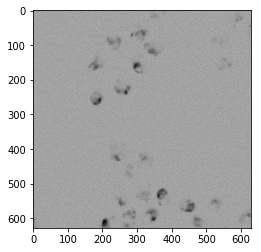

In [94]:
plt.imshow(255-test_img[11],'gray')
plt.show()

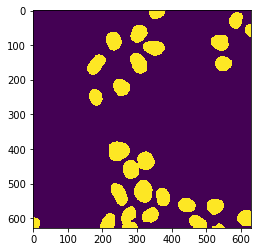

In [24]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel,iterations=2)
plt.imshow(opening)
plt.show()

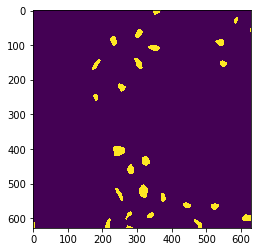

In [175]:
# sure background area
sure_bg = cv2.dilate(mask,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(mask,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(sure_fg)
plt.show()

In [162]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1
# Now, mark the region of unknown with zero
markers[unknown == 1] = 0

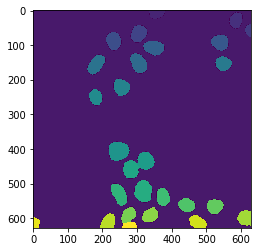

In [163]:
rgb = cv2.cvtColor(test_data[11],cv2.COLOR_GRAY2BGR)
markers2 = cv2.watershed(rgb,markers)
imgrgb[markers2==-1] = [255,0,0]
plt.imshow(markers2)
plt.show()

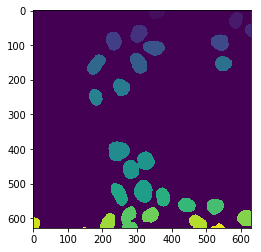

In [139]:
plt.imshow(test_data[11])
plt.show()

In [166]:
num1 = len(np.unique(test_data[11]))-1
num2 = len(np.unique(markers2))-1
num2

27

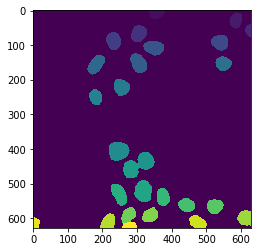

In [165]:
newmark=markers2
newmark[markers2==-1] = 1
newmark = newmark-1
plt.imshow(newmark)
plt.show()